In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import math
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization, ZeroPadding2D
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## 1. Data overview

In [2]:
data = np.load('../datasets/pneumoniamnist.npz')

In [3]:
print(data.files)

['train_images', 'val_images', 'test_images', 'train_labels', 'val_labels', 'test_labels']


In [4]:
x_train = data['train_images']
x_test = data['test_images']
x_val = data['val_images']

y_train = data['train_labels']
y_test = data['test_labels']
y_val = data['val_labels']

In [5]:
print("Shape of x_train:", x_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of x_test:", x_test.shape)
print("Shape of y_test:", y_test.shape)
print("Shape of x_val:", x_val.shape)
print("Shape of y_val:", y_val.shape)

Shape of x_train: (4708, 28, 28)
Shape of y_train: (4708, 1)
Shape of x_test: (624, 28, 28)
Shape of y_test: (624, 1)
Shape of x_val: (524, 28, 28)
Shape of y_val: (524, 1)


 The shapes indicate that the images have dimensions of 28x28 pixels, and there are a total of 4708 training samples, 624 test samples, and 524 validation samples.

In [6]:
img_size = 28

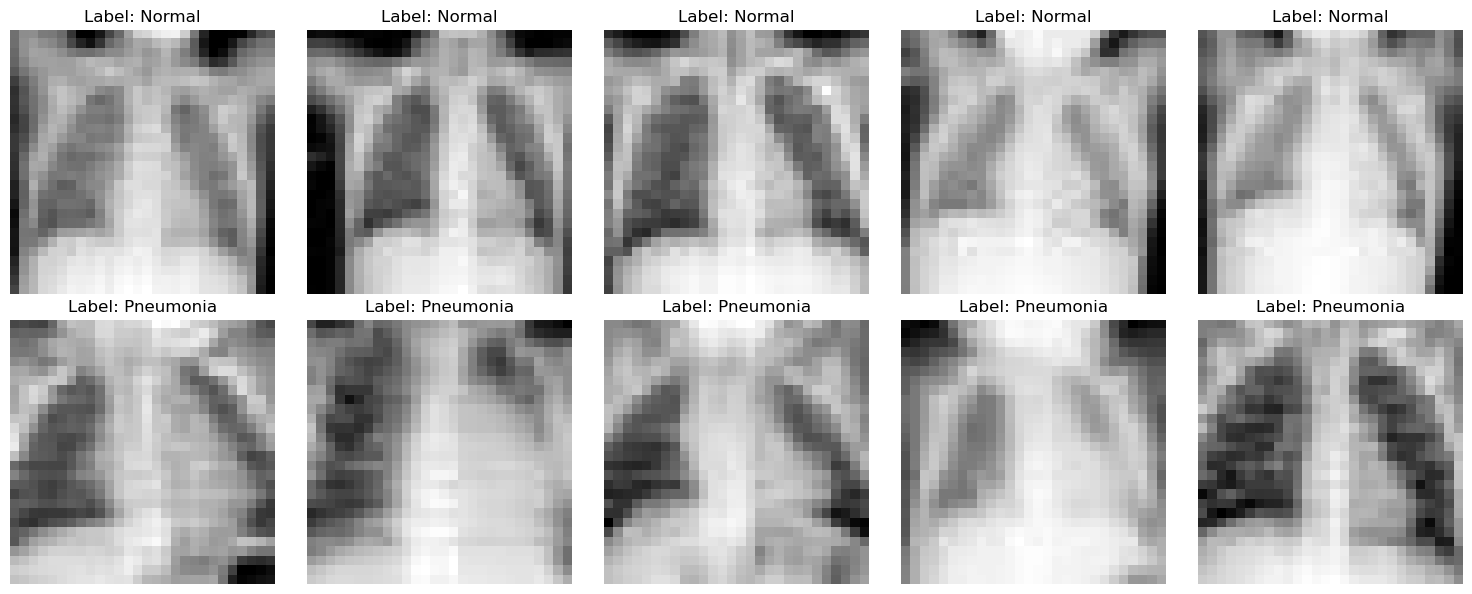

In [7]:
num_images_per_class = 5

# Find indices of "Normal" (label 0) and "Pneumonia" (label 1) images
normal_indices = [i for i, label in enumerate(y_train.flatten()) if label == 0]
pneumonia_indices = [i for i, label in enumerate(y_train.flatten()) if label == 1]

# Randomly select a few indices for each class
random_normal_indices = random.sample(normal_indices, num_images_per_class)
random_pneumonia_indices = random.sample(pneumonia_indices, num_images_per_class)

# Plot the images in a grid
fig, axes = plt.subplots(2, num_images_per_class, figsize=(15, 6))

# Display "Normal" images
for i, index in enumerate(random_normal_indices):
    axes[0, i].imshow(x_train[index], cmap='gray')
    axes[0, i].set_title(f"Label: Normal")
    axes[0, i].axis('off')

# Display "Pneumonia" images
for i, index in enumerate(random_pneumonia_indices):
    axes[1, i].imshow(x_train[index], cmap='gray')
    axes[1, i].set_title(f"Label: Pneumonia")
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'pneumonia')

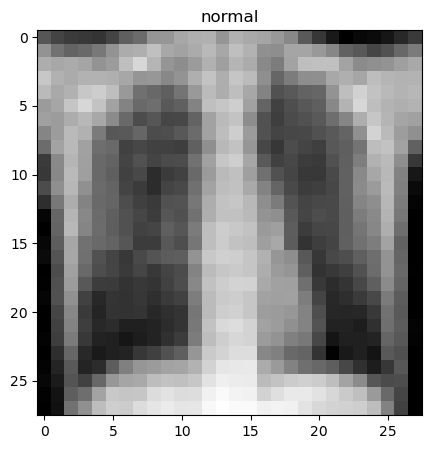

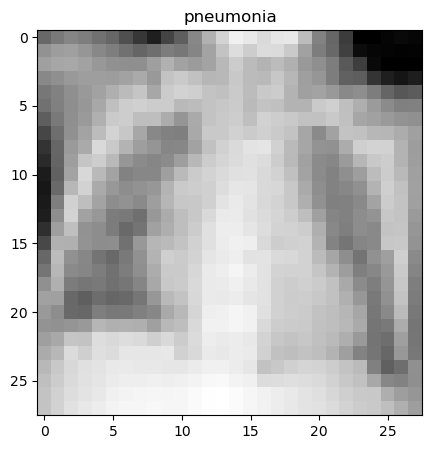

In [8]:
plt.figure(figsize = (5,5))
plt.imshow(x_train[normal_indices[0]], cmap='gray')
plt.title('normal')

plt.figure(figsize = (5,5))
plt.imshow(x_train[pneumonia_indices[0]], cmap='gray')
plt.title('pneumonia')

d:\Software\conda\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Software\conda\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Software\conda\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Software\conda\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\S

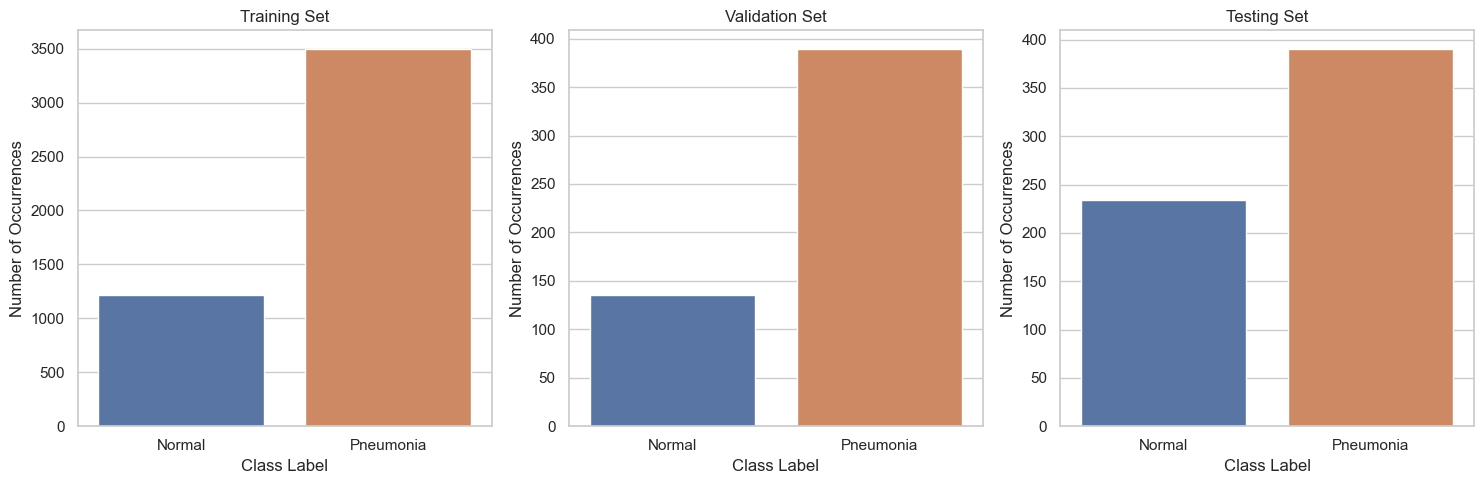

In [9]:
##Classes distribution in the training dataset.
# Replace numerical labels with class names
class_names = ["Normal", "Pneumonia"]

# Plot the bar chart
sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Training set
sns.countplot(x=y_train.flatten(), ax=axes[0])
axes[0].set_title('Training Set')
axes[0].set_xlabel('Class Label')
axes[0].set_ylabel('Number of Occurrences')
axes[0].set_xticklabels(class_names)  # Replace x-axis labels with class names

# Validation set
sns.countplot(x=y_val.flatten(), ax=axes[1])
axes[1].set_title('Validation Set')
axes[1].set_xlabel('Class Label')
axes[1].set_ylabel('Number of Occurrences')
axes[1].set_xticklabels(class_names)  # Replace x-axis labels with class names

# Testing set
sns.countplot(x=y_test.flatten(), ax=axes[2])
axes[2].set_title('Testing Set')
axes[2].set_xlabel('Class Label')
axes[2].set_ylabel('Number of Occurrences')
axes[2].set_xticklabels(class_names)  # Replace x-axis labels with class names

plt.tight_layout()
plt.show()

## Data Preprocessing

Data normalization: reduce the effect of lightning, convert the data range from 0-255 to 0-1

In [10]:
# Data normalization #/255 may reduce the precision
x_train1 = ((np.array(x_train) / 255) - 0.5) * 2
x_val1 = ((np.array(x_val) / 255) - 0.5) * 2
x_test1 = ((np.array(x_test) / 255) - 0.5) * 2

# The images up until this point are represented by 2D arrays with dimensions of WIDTH x HEIGHT.
# In this final transformation the arrays are flattened into 1D arrays with dimensions of 1 x (WIDTH*HEIGHT).
x_train_flat = x_train1.reshape(-1, img_size*img_size)
y_train = np.array(y_train)

x_val_flat = x_val1.reshape(-1, img_size* img_size)
y_val = np.array(y_val)

x_test_flat = x_test1.reshape(-1, img_size*img_size)
y_test = np.array(y_test)

Apply Gaussiam blur to the images: This helps to emphasize the features in the image.

In [14]:
# Apply Gaussian blur to the dataset.
import cv2
'''
alpha: Weight of the original image. Increasing alpha increases the contribution of the original image, making the result closer to the original.
beta: Weight of the blurred version. Increasing beta increases the contribution of the blurred version, making the result closer to the blurred image.
'''
# Function to apply Gaussian Blur to a single image
def apply_gaussian_blur_weighted(image, alpha=2, beta=-0.2):
    blurred_image = cv2.addWeighted(image, alpha, cv2.GaussianBlur(image, (0, 0), 2), beta, 0)
    return blurred_image

# Apply Gaussian Blur to the entire dataset
x_train_blurred = np.array([apply_gaussian_blur_weighted(img) for img in x_train])
x_val_blurred = np.array([apply_gaussian_blur_weighted(img) for img in x_val])
x_test_blurred = np.array([apply_gaussian_blur_weighted(img) for img in x_test])

#use for svm model
x_train_blurred_flat = x_train_blurred.reshape(-1, img_size*img_size)
x_val_blurred_flat = x_val_blurred.reshape(-1, img_size*img_size)
x_test_blurred_flat = x_test_blurred.reshape(-1, img_size*img_size)

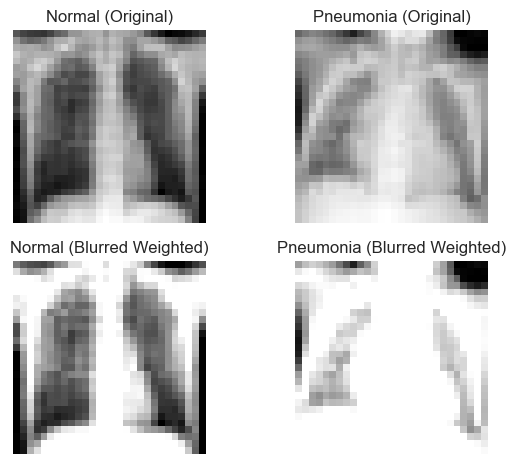

In [15]:
# Display a sample of original and blurred images for comparison
# Original images
plt.subplot(2, 2, 1)
plt.imshow(x_train[normal_indices[0]].reshape(img_size, img_size), cmap='gray')
plt.title('Normal (Original)')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(x_train[pneumonia_indices[0]].reshape(img_size, img_size), cmap='gray')
plt.title('Pneumonia (Original)')
plt.axis('off')

# Weighted blurred images
plt.subplot(2, 2, 3)
plt.imshow(x_train_blurred[normal_indices[0]].reshape(img_size, img_size), cmap='gray')
plt.title('Normal (Blurred Weighted)')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(x_train_blurred[pneumonia_indices[0]].reshape(img_size, img_size), cmap='gray')
plt.title('Pneumonia (Blurred Weighted)')
plt.axis('off')

plt.tight_layout()
plt.show()



## Model Training -SVM/ CNN

#### Training SVM Model

Classifier Training:
 _`GridSearchCV`_: Used for an exhaustive search over specified parameter values for an SVM classifier.

 _`SVM Classifier`_: Based on C-Support Vector Classification, implemented using libsvm. It handles multiclass support according to a one-vs-one scheme.

_`Parameter Exploration:`_

- gamma: Kernel coefficient for "rbf," "poly," and "sigmoid" types of kernels. Used with the argument "scale."
- kernel: Different types of kernels - "linear," "poly," "rbf," "sigmoid," and "precomputed."
For the "poly" kernel, different values for the degree of the polynomial kernel function were tested.
- class_weight: Tested as "balanced" and "none."
- n_splits: Determines the number of cross-validation splits.
_Validation Sets:_ Automatically created during training from the training images. The initial validation set was merged with the training set.

_`Best Combination:`_ Identified a specific combination of parameters and their values that gave the maximum precision for both classes.

In [16]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix

def svm_classifier(training_set, training_labels):
    # Fitting the classifiers.
    param_grid = {
        'C': [1e0, 5e0, 1e1, 5e1, 1e2, 5e2, 1e3, 5e3, 1e4, 5e4],
        'gamma': ['auto', 'auto', 'auto', 'auto', 'auto', 'auto', 'auto']
    }

    # Creating the SVM classifier with GridSearchCV
    clf = GridSearchCV(SVC(kernel='poly'), param_grid, verbose=3)
    clf.fit(training_set, training_labels)

    # Printing the best parameters found by grid search
    print("Best parameters found by grid search:")
    print(clf.best_params_)

    # Printing the best estimator found by grid search
    print("\nBest estimator found by grid search:")
    print(clf.best_estimator_)

    return clf


In [17]:
def test_images(clf, test_images, test_labels):
    train_pred = clf.predict(test_images)
    print(classification_report(test_labels, train_pred))
    print(confusion_matrix(test_labels, train_pred))
    return train_pred

In [20]:
clf = svm_classifier(x_train_flat, y_train.ravel())

Fitting 5 folds for each of 70 candidates, totalling 350 fits
[CV 1/5] END .................C=1.0, gamma=auto;, score=0.743 total time=   4.7s
[CV 2/5] END .................C=1.0, gamma=auto;, score=0.742 total time=   4.7s
[CV 3/5] END .................C=1.0, gamma=auto;, score=0.742 total time=   4.0s
[CV 4/5] END .................C=1.0, gamma=auto;, score=0.743 total time=   3.9s
[CV 5/5] END .................C=1.0, gamma=auto;, score=0.742 total time=   3.8s
[CV 1/5] END .................C=1.0, gamma=auto;, score=0.743 total time=   4.0s
[CV 2/5] END .................C=1.0, gamma=auto;, score=0.742 total time=   3.9s
[CV 3/5] END .................C=1.0, gamma=auto;, score=0.742 total time=   3.6s
[CV 4/5] END .................C=1.0, gamma=auto;, score=0.743 total time=   3.5s
[CV 5/5] END .................C=1.0, gamma=auto;, score=0.742 total time=   3.6s
[CV 1/5] END .................C=1.0, gamma=auto;, score=0.743 total time=   3.4s
[CV 2/5] END .................C=1.0, gamma=auto

In [87]:
train_pred = test_images(clf, x_test_flat, y_test.ravel())
results_matrix_test = confusion_matrix(y_test.ravel(), train_pred)

              precision    recall  f1-score   support

           0       0.97      0.60      0.74       234
           1       0.81      0.99      0.89       390

    accuracy                           0.84       624
   macro avg       0.89      0.80      0.82       624
weighted avg       0.87      0.84      0.83       624

[[141  93]
 [  4 386]]


Show the heatmap based on the confusion matrix

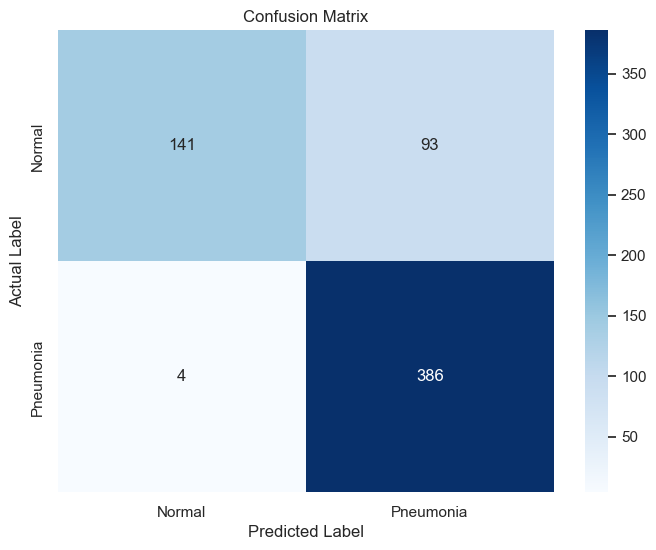

In [88]:
plt.figure(figsize=(8, 6))
sns.heatmap(results_matrix_test, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix")
plt.show()

Train SVM on the Gaussian Blurred dataset

In [45]:
clf2 = svm_classifier(x_train_blurred_flat, y_train.ravel())

Fitting 5 folds for each of 70 candidates, totalling 350 fits
[CV 1/5] END .................C=1.0, gamma=auto;, score=0.930 total time=   1.1s
[CV 2/5] END .................C=1.0, gamma=auto;, score=0.937 total time=   1.1s
[CV 3/5] END .................C=1.0, gamma=auto;, score=0.938 total time=   1.1s
[CV 4/5] END .................C=1.0, gamma=auto;, score=0.936 total time=   1.1s
[CV 5/5] END .................C=1.0, gamma=auto;, score=0.933 total time=   1.1s
[CV 1/5] END .................C=1.0, gamma=auto;, score=0.930 total time=   1.1s
[CV 2/5] END .................C=1.0, gamma=auto;, score=0.937 total time=   1.2s
[CV 3/5] END .................C=1.0, gamma=auto;, score=0.938 total time=   1.1s
[CV 4/5] END .................C=1.0, gamma=auto;, score=0.936 total time=   1.1s
[CV 5/5] END .................C=1.0, gamma=auto;, score=0.933 total time=   1.1s
[CV 1/5] END .................C=1.0, gamma=auto;, score=0.930 total time=   1.1s
[CV 2/5] END .................C=1.0, gamma=auto

In [48]:
train_pred_blurred = test_images(clf2, x_test_blurred_flat, y_test.ravel())
results_matrix_test = confusion_matrix(y_test.ravel(), train_pred_blurred)

              precision    recall  f1-score   support

           0       0.91      0.58      0.71       234
           1       0.79      0.97      0.87       390

    accuracy                           0.82       624
   macro avg       0.85      0.77      0.79       624
weighted avg       0.84      0.82      0.81       624

[[135  99]
 [ 13 377]]


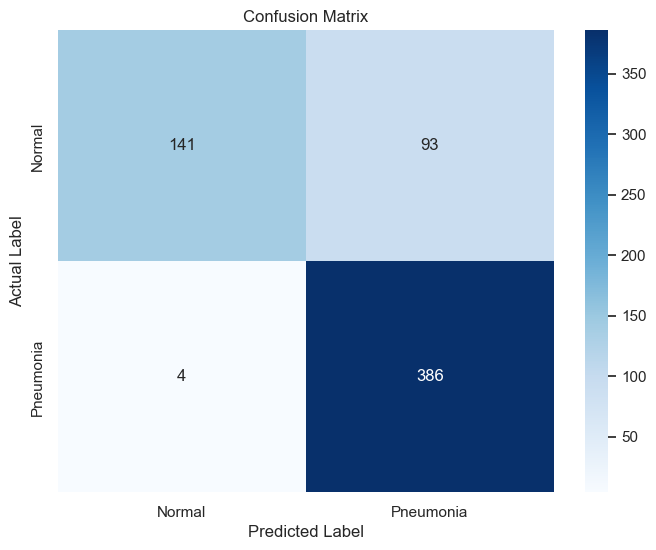

In [85]:
# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(results_matrix_test, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("Actual Label")
plt.title("Confusion Matrix")
plt.show()

## CNN

Preprocessing for CNN

In [23]:
x_train2 = np.array(x_train)/255
x_val2 = np.array(x_val) / 255
x_test2 = np.array(x_test) / 255

In [24]:
x_train2 = x_train2.reshape(-1, img_size, img_size, 1)
x_val2 = x_val2.reshape(-1, img_size, img_size, 1)
x_test2 = x_test2.reshape(-1, img_size, img_size, 1)

In [25]:
# Data augmentation
datagen = ImageDataGenerator(
        featurewise_center=False,             # set input mean to 0 over the dataset
        samplewise_center=False,              # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,   # divide each input by its std
        zca_whitening=False,    # apply ZCA whitening
        rotation_range = 30,    # random rotation in the range 0 to 180 degrees
        zoom_range = 0.2,       # random zoom  
        width_shift_range=0.1,  # random horizontal shift  (fraction of total width)
        height_shift_range=0.1,  # random vertical shift   (fraction of total height)
        horizontal_flip = True,  # random horizontal flip 
        vertical_flip=False)  # random vertical flip 

datagen.fit(x_train2)

`Model Training:`  
Key components of the architecture:  
    - Convolutional layers with ReLU activation.  
    - Batch normalization after each convolutional layer.  
    - MaxPooling layers for downsampling.  
    - Dropout layers for regularization.  
    - Dense layers with ReLU activation for final classification.  
    - Sigmoid activation in the output layer for binary classification.  
    - Binary crossentropy loss for binary classification.  

In [26]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (28,28,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 28, 28, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 14, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 14, 14, 64)       2

Use learning rate reduction to avoid small learning rate(overfitting) and large learning rate(underfitting)

In [27]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [28]:
history = model.fit(x_train2, y_train, epochs = 12 , validation_data = (x_val2, y_val) ,callbacks = [learning_rate_reduction])

Epoch 1/12
148/148 [==============================] - 8s 32ms/step - loss: 0.2426 - accuracy: 0.9133 - val_loss: 1.2179 - val_accuracy: 0.7424 - lr: 0.0010
Epoch 2/12
148/148 [==============================] - 4s 24ms/step - loss: 0.1320 - accuracy: 0.9501 - val_loss: 0.8440 - val_accuracy: 0.7424 - lr: 0.0010
Epoch 3/12
148/148 [==============================] - 3s 23ms/step - loss: 0.1071 - accuracy: 0.9609 - val_loss: 0.6379 - val_accuracy: 0.8282 - lr: 0.0010
Epoch 4/12
148/148 [==============================] - 3s 22ms/step - loss: 0.0953 - accuracy: 0.9658 - val_loss: 0.0819 - val_accuracy: 0.9676 - lr: 0.0010
Epoch 5/12
148/148 [==============================] - 3s 22ms/step - loss: 0.0958 - accuracy: 0.9673 - val_loss: 0.2374 - val_accuracy: 0.8931 - lr: 0.0010
Epoch 6/12
146/148 [============================>.] - ETA: 0s - loss: 0.0743 - accuracy: 0.9707
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
148/148 [==============================] - 3s 22

In [29]:
print("Test loss - " , model.evaluate(x_test2,y_test)[0])
print("Test Accuracy - " , model.evaluate(x_test2,y_test)[1]*100 , "%")

20/20 [==============================] - 0s 12ms/step - loss: 1.2933 - accuracy: 0.8670
Test loss -  1.2933353185653687
20/20 [==============================] - 0s 7ms/step - loss: 1.2933 - accuracy: 0.8670
Test Accuracy -  86.69871687889099 %


With augmentation data

In [30]:
history = model.fit(datagen.flow(x_train2, y_train, batch_size = 32) ,epochs = 12 , validation_data = datagen.flow(x_val2, y_val) ,callbacks = [learning_rate_reduction])

Epoch 1/12
148/148 [==============================] - 7s 33ms/step - loss: 0.9501 - accuracy: 0.8830 - val_loss: 0.6424 - val_accuracy: 0.8931 - lr: 2.7000e-05
Epoch 2/12
148/148 [==============================] - 4s 27ms/step - loss: 0.4702 - accuracy: 0.9012 - val_loss: 0.4249 - val_accuracy: 0.8817 - lr: 2.7000e-05
Epoch 3/12
146/148 [============================>.] - ETA: 0s - loss: 0.3348 - accuracy: 0.9040
Epoch 3: ReduceLROnPlateau reducing learning rate to 8.100000013655517e-06.
148/148 [==============================] - 4s 23ms/step - loss: 0.3316 - accuracy: 0.9046 - val_loss: 0.3155 - val_accuracy: 0.8779 - lr: 2.7000e-05
Epoch 4/12
148/148 [==============================] - 4s 24ms/step - loss: 0.2804 - accuracy: 0.9025 - val_loss: 0.2354 - val_accuracy: 0.9122 - lr: 8.1000e-06
Epoch 5/12
148/148 [==============================] - 4s 24ms/step - loss: 0.2972 - accuracy: 0.9059 - val_loss: 0.2716 - val_accuracy: 0.8931 - lr: 8.1000e-06
Epoch 6/12
148/148 [===================

In [31]:
print("Test loss - " , model.evaluate(x_test2,y_test)[0])
print("Test Accuracy - " , model.evaluate(x_test2,y_test)[1]*100 , "%")

20/20 [==============================] - 0s 8ms/step - loss: 0.2351 - accuracy: 0.9087
Test loss -  0.2351105958223343
20/20 [==============================] - 0s 7ms/step - loss: 0.2351 - accuracy: 0.9087
Test Accuracy -  90.86538553237915 %


Model Analysis

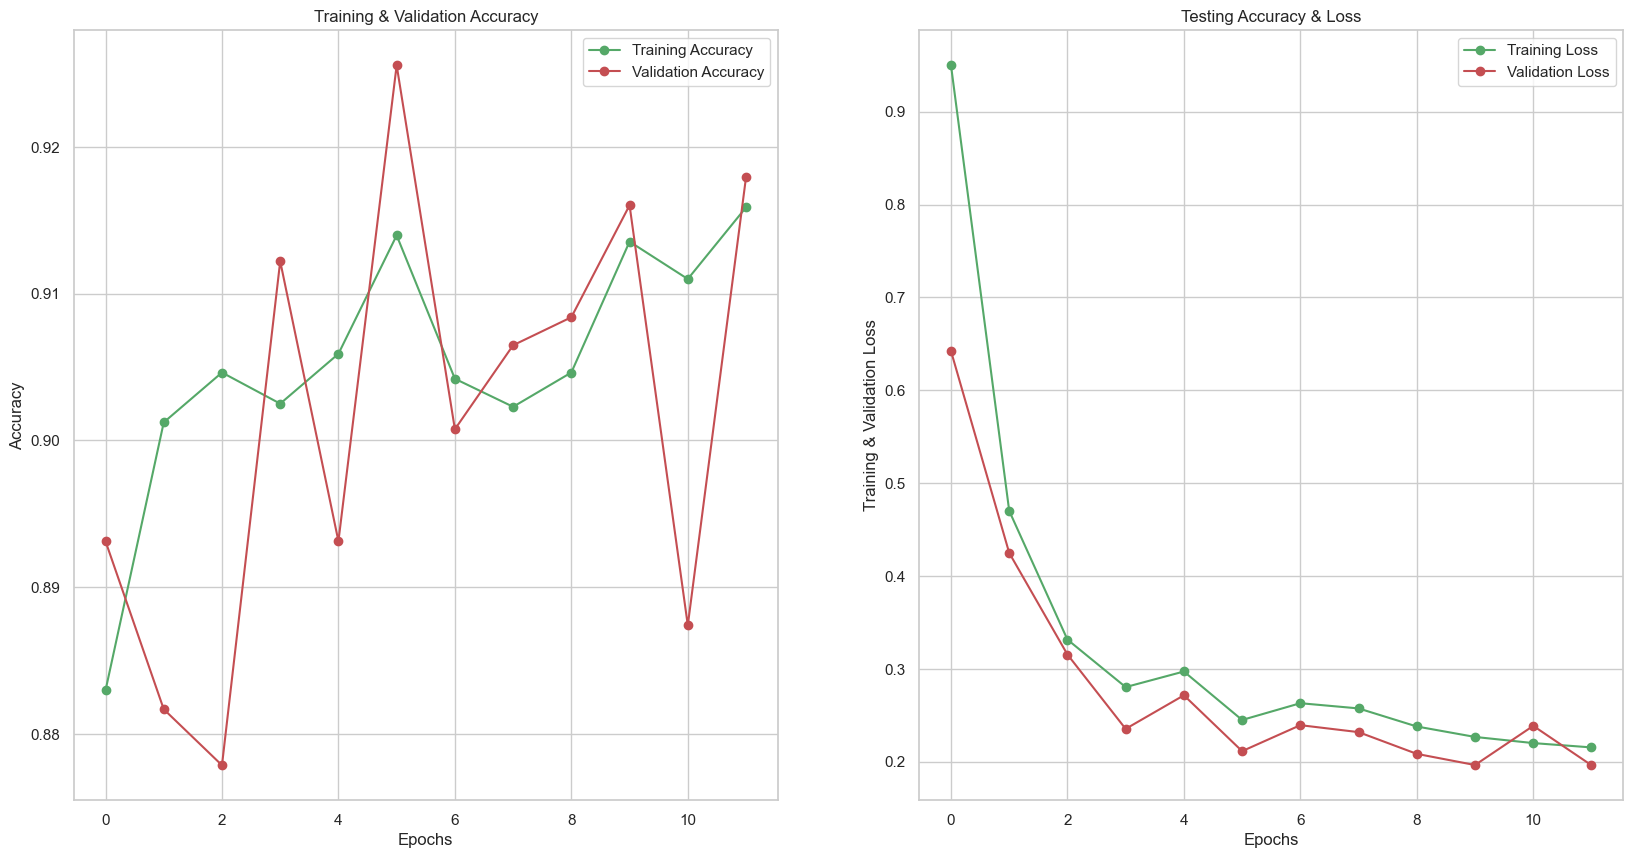

In [32]:
epochs = [i for i in range(12)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

20/20 [==============================] - 0s 5ms/step


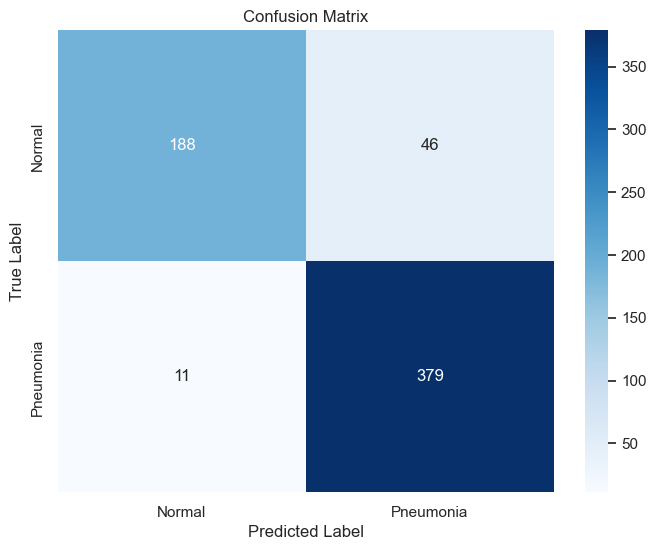

In [86]:
predictions = model.predict(x_test2)
predicted_labels = np.round(predictions).astype(int)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, predicted_labels)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


## Model Prediction

In [83]:
def display_images_in_layout(images, original_labels, predicted_labels, class_names, num_columns=5, num_imgs=20):
    # Calculate the number of rows based on num_columns
    num_rows = int(num_imgs / num_columns)

    # Randomly generate index of shown images
    random_idx = np.random.choice(len(images), num_imgs, replace=False)

    # Create subplots
    fig, axs = plt.subplots(num_rows, num_columns, figsize=(15, 3 * num_rows))

    # Loop through images and labels to display
    for i in range(len(random_idx)):
        row, col = divmod(i, num_columns)
        # Display image
        ax = axs[row, col]
        ax.imshow(images[random_idx[i]], cmap='gray')
        
        # Map numeric labels to class names
        original_label = class_names[int(original_labels[random_idx[i]])]
        predicted_label = class_names[int(predicted_labels[random_idx[i]])]
        title_color = 'green' if original_label == predicted_label else 'red'
        
        
        ax.set_title(f"Original: {original_label}\nPredicted: {predicted_label}", color = title_color)
        ax.axis('off')

    # Adjust layout
    plt.tight_layout()
    plt.show()

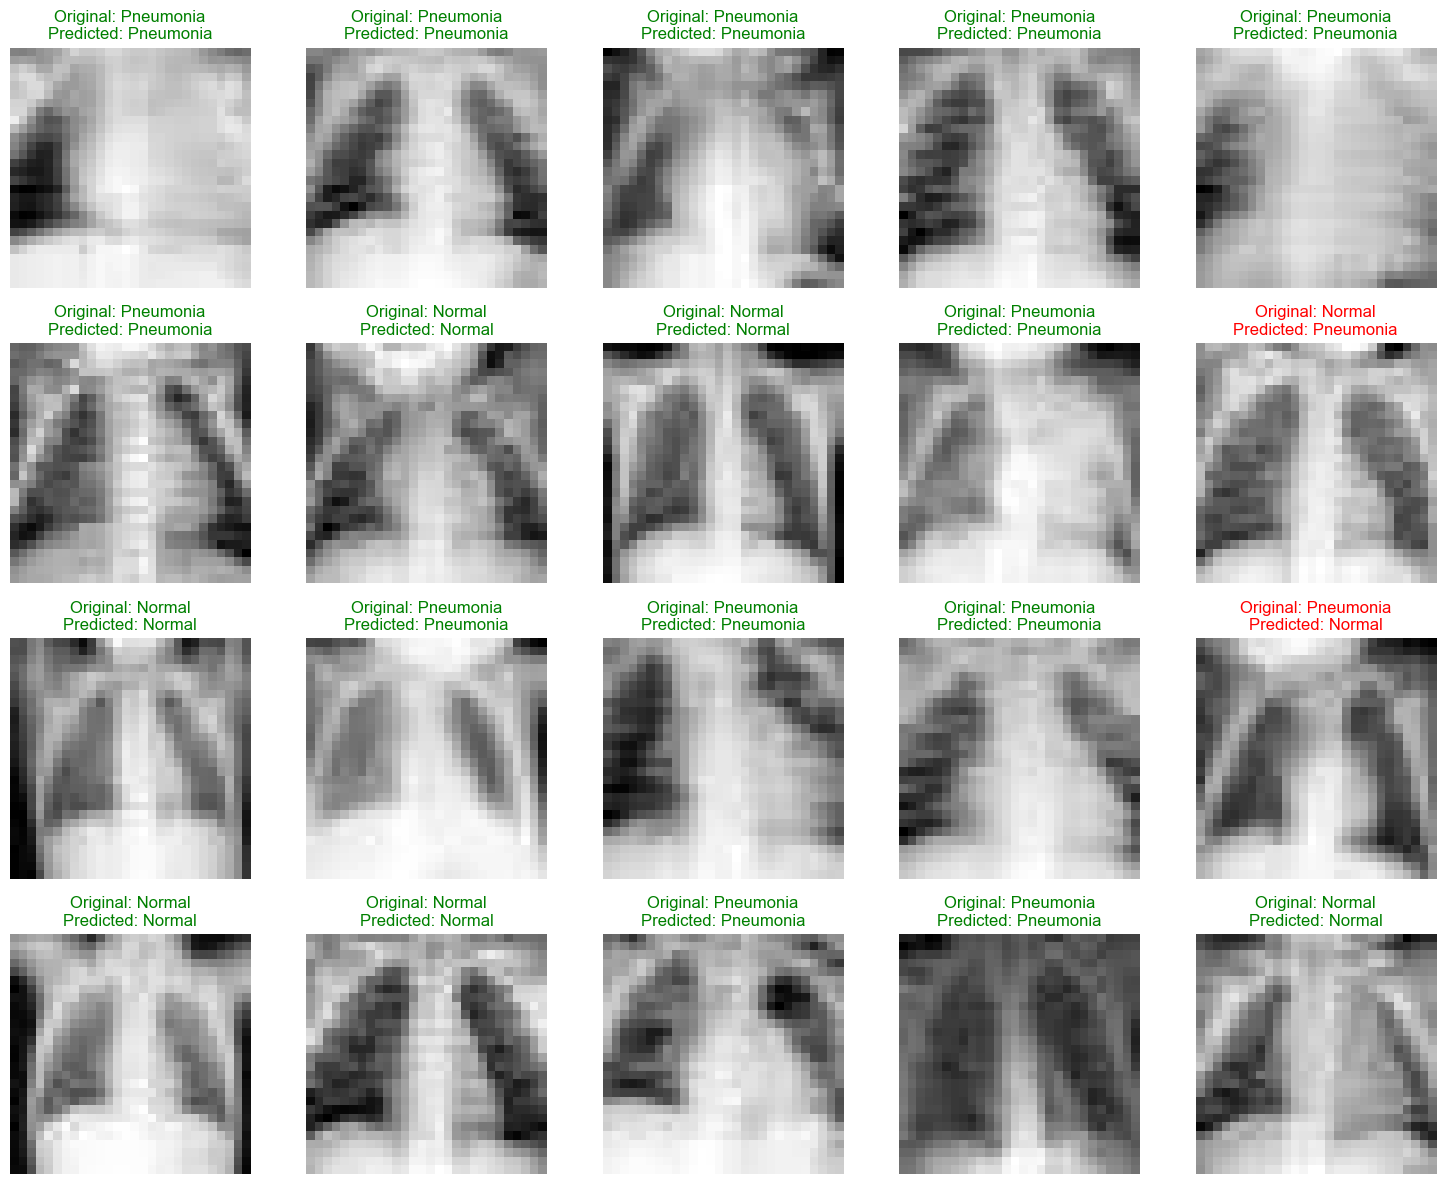

In [84]:
class_names = ["Normal","Pneumonia"]

display_images_in_layout(x_test2, y_test, predicted_labels, class_names, num_columns=5, num_imgs=20)